In [1]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import os,sys
#自作コード
sys.path.append("../pytorch_lightning")
from utils_data import load_data

print(sys.path)



['/Users/soriiieee/work2/sci/d0727/deep_learning_pytorch/jupyter', '/anaconda3/envs/sori_torch/lib/python37.zip', '/anaconda3/envs/sori_torch/lib/python3.7', '/anaconda3/envs/sori_torch/lib/python3.7/lib-dynload', '', '/Users/soriiieee/.local/lib/python3.7/site-packages', '/anaconda3/envs/sori_torch/lib/python3.7/site-packages', '/anaconda3/envs/sori_torch/lib/python3.7/site-packages/IPython/extensions', '/Users/soriiieee/.ipython', '../pytorch_lightning']


In [2]:
import warnings
warnings.filterwarnings("ignore")
df = load_data()

import seaborn as sns
# df.shape #(21000, 31)
# df.date.dt.date.values[0],df.date.dt.date.values[-1]
# (datetime.date(2013, 1, 1), datetime.date(2017, 12, 1))
df.columns

Index(['agency', 'sku', 'volume', 'date', 'industry_volume', 'soda_volume',
       'avg_max_temp', 'price_regular', 'price_actual', 'discount',
       'avg_population_2017', 'avg_yearly_household_income_2017', 'easter_day',
       'good_friday', 'new_year', 'christmas', 'labor_day', 'independence_day',
       'revolution_day_memorial', 'regional_games', 'fifa_u_17_world_cup',
       'football_gold_cup', 'beer_capital', 'music_fest',
       'discount_in_percent', 'timeseries', 'time_idx', 'month', 'log_volume',
       'avg_volume_by_sku', 'avg_volume_by_agency'],
      dtype='object')

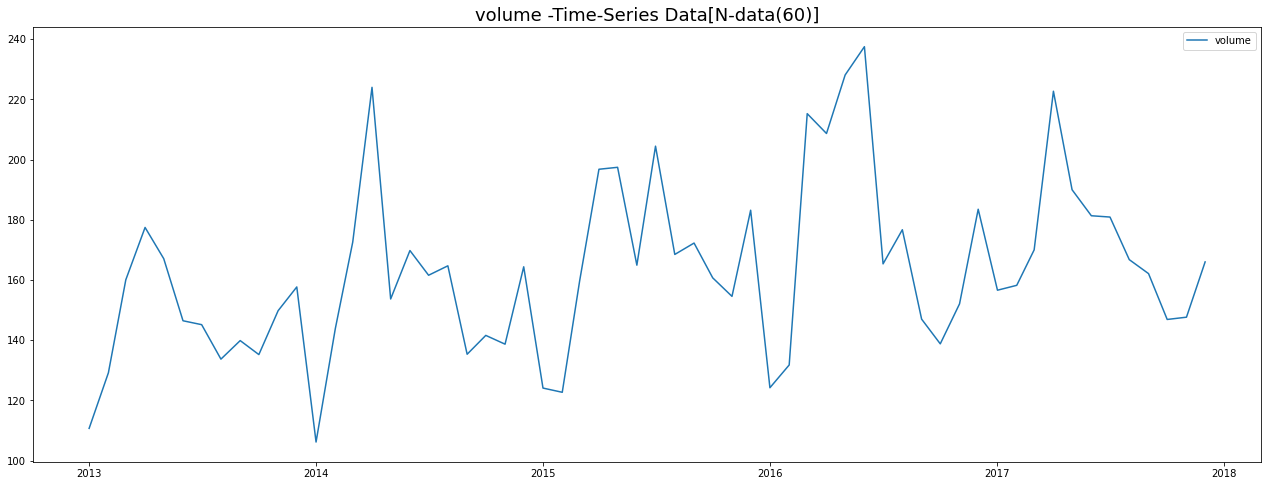

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
237,Agency_22,SKU_02,110.700,2013-01-01,492612703,718394219,25.845238,1167.000000,1067.257500,99.742500,...,-,-,-,8.546915,4,0,1,4.706824,1408.867200,103.80546
667,Agency_22,SKU_02,129.168,2013-02-01,431937346,753938444,29.313095,1167.000000,1067.398045,99.601955,...,-,-,-,8.534872,4,1,2,4.861114,1703.182131,121.04766
986,Agency_22,SKU_02,160.056,2013-03-01,509281531,892192092,29.422353,1207.051367,1105.057650,101.993717,...,-,-,music_fest,8.449824,4,2,3,5.075524,1952.543572,153.84672
1071,Agency_22,SKU_02,177.444,2013-04-01,532390389,838099501,32.433721,1235.187500,1129.921865,105.265635,...,-,-,-,8.522239,4,3,4,5.178655,2107.537781,163.15866
1740,Agency_22,SKU_02,167.076,2013-05-01,551755254,864420003,32.157647,1246.638049,1138.922471,107.715578,...,-,-,-,8.640485,4,4,5,5.118449,2331.744327,152.62596


In [11]:
import matplotlib.pyplot as plt
def plot_ts(df,c,time_col=None):
    f,ax = plt.subplots(figsize=(22,8))
    n_data = df.shape[0]
    if time_col:
        df = df.set_index(time_col)
    ax.plot(df[c],label=c)
    ax.legend(loc="upper right")
    ax.set_title(f"{c} -Time-Series Data[N-data({n_data})]",fontsize=18)
    plt.show()
    return

def plot_count(df,c,hue=None):
#     count = df.value_counts(c)
    n_unique = df[c].nunique()
#     print(n_unique)
#     sys.exit()
    
    f,ax = plt.subplots(figsize=(22,8))
#     ax.plot(df[c],label=c)
    if hue:
        sns.countplot(x =c,hue=hue,data=df,ax=ax)
    else:
        sns.countplot(x =c,data=df,ax=ax)
#     ax.legend(loc="upper right")
    ax.set_title(f"{c} -UNIQE-VALUE={n_unique}",fontsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()
    return

def plot_bins(df,c):
    f,ax = plt.subplots(figsize=(22,8))
    sns.distplot(x =c,data=df,ax=ax)
    ax.set_title(f"{c} -DISTPLOT",fontsize=18)
    plt.show()
    return


# plot_count(df,c="easter_day")
df = load_data(preprocess=True, reset=False)
df = df[(df["sku"] == "SKU_02")&(df["agency"] =="Agency_22")]
plot_ts(df,"volume",time_col="date")
df.head()

In [4]:
df.dtypes

agency                                      object
sku                                         object
volume                                     float64
date                                datetime64[ns]
industry_volume                              int64
soda_volume                                  int64
avg_max_temp                               float64
price_regular                              float64
price_actual                               float64
discount                                   float64
avg_population_2017                          int64
avg_yearly_household_income_2017             int64
easter_day                                category
good_friday                               category
new_year                                  category
christmas                                 category
labor_day                                 category
independence_day                          category
revolution_day_memorial                   category
regional_games                 

In [16]:
df = load_data(preprocess=True, reset=False)
df.columns

Index(['agency', 'sku', 'volume', 'date', 'industry_volume', 'soda_volume',
       'avg_max_temp', 'price_regular', 'price_actual', 'discount',
       'avg_population_2017', 'avg_yearly_household_income_2017', 'easter_day',
       'good_friday', 'new_year', 'christmas', 'labor_day', 'independence_day',
       'revolution_day_memorial', 'regional_games', 'fifa_u_17_world_cup',
       'football_gold_cup', 'beer_capital', 'music_fest',
       'discount_in_percent', 'timeseries', 'time_idx', 'month', 'log_volume',
       'avg_volume_by_sku', 'avg_volume_by_agency'],
      dtype='object')

In [17]:
max_prediction_length = 6
max_encoder_length = 24
trainig_cutoff = df["time_idx"].max() - max_prediction_length
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
special_days = ["easter_day","good_friday","new_year","christmas","labor_day","independence_day","revolution_day_memorial","regional_games","fifa_u_17_world_cup","football_gold_cup","beer_capital","music_fest"]

training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= trainig_cutoff],
    time_idx = "time_idx",
    target = "volume",
    group_ids = ["agency","sku"], #同時刻で被るもの(地点/商品)などをまとめる,
    min_encoder_length = max_encoder_length // 2,
    max_encoder_length = max_encoder_length,
    min_prediction_length = 1,
    max_prediction_length = max_prediction_length,
    static_categoricals=["agency","sku"],
    static_reals=["avg_population_2017","avg_yearly_household_income_2017"],
    time_varying_known_categoricals = ["special_days","month"],
    variable_groups = {"special_days": special_days},
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(training,df,predict=True, stop_randomization=True)
#create dataloaders for model
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size,num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size*10,num_workers=0)


In [23]:
#baseline model
actuals = torch.cat([ y for x,(y,weight) in iter(val_dataloader)])
# actuals[1]
baseline_prediction = Baseline().predict(val_dataloader)
baseline_prediction.size()
(actuals - baseline_prediction).abs().mean().item()

293.0088195800781

In [25]:
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus = 0,
    gradient_clip_val=0.1
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate = 0.03,
    hidden_size = 16, 
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,
    loss = QuantileLoss(),
    reduce_on_plateau_patience=4,
)

print(f"Number os oparameters in network: {tft.size()/1e3:.2f}k")


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number os oparameters in network: 29.67k


In [32]:
print(train_dataloader)
print(val_dataloader)

In [33]:
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

NotImplementedError: `val_dataloader` must be implemented to be used with the Lightning Trainer